In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from torchvision.models import vgg16_bn

In [2]:
path = untar_data(URLs.COCO_SAMPLE); path.ls(), len(get_files(path/'train_sample'))

([PosixPath('/home/jupyter/.fastai/data/coco_sample/annotations'),
  PosixPath('/home/jupyter/.fastai/data/coco_sample/train_sample')],
 21837)

In [3]:
path_img = path/'train_sample'

In [4]:
src = (ImageImageList.from_folder(path_img)
       .use_partial_data(1.0, seed=42)
       .split_by_rand_pct(0.1, seed=42))

In [5]:
bs,sz = 42,128
bs,sz = 128,128

dbch = (src.label_from_func(lambda x: x)
        .transform(get_transforms(), tfm_y=True, size=sz)
        .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

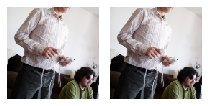

In [6]:
dbch.show_batch(rows=1, figsize=(3,3))

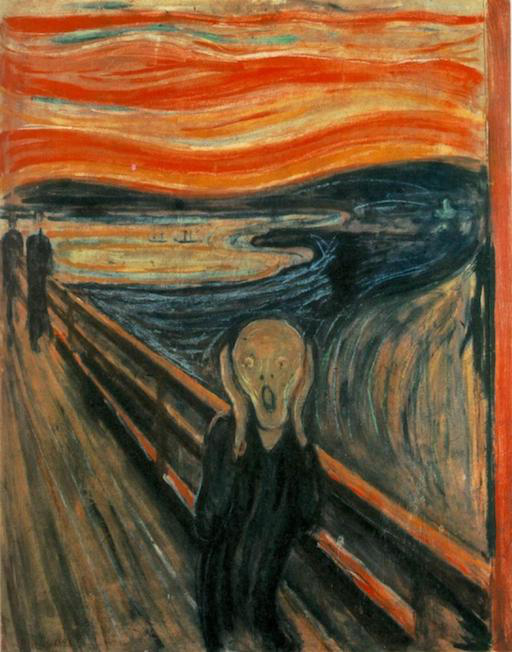

In [7]:
style_img = open_image('styles/the_scream.jpg')
style_timg = normalize(style_img.px, *map(tensor, imagenet_stats)).cuda()[None]; style_img

In [8]:
def gram(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [9]:
base_loss = F.l1_loss
class FSTLoss(nn.Module):
    def __init__(self, m_feat, cnt_ls, stl_ls, cnt_lsw, stl_lsw, stl_loss_mult=1e6):
        super().__init__()
        assert len(cnt_ls) == len(cnt_lsw)
        assert len(stl_ls) == len(stl_lsw)
        self.m_feat,self.cnt_ls,self.stl_ls,self.stl_loss_mult=m_feat,cnt_ls,stl_ls,stl_loss_mult
        self.cnt_lsw = tensor(cnt_lsw).float() / sum(cnt_lsw)
        self.stl_lsw = tensor(stl_lsw).float() / sum(stl_lsw)
        self.cnt_hooks = hook_outputs(cnt_ls, detach=False)
        self.stl_hooks = hook_outputs(stl_ls, detach=False)
        self.metric_names = ['style', 'content']
        
    def register_style(self, timg):  _,self.stl_fs = self.get_fs(timg, True)

    def get_fs(self, x, clone=False):
        self.m_feat(x)
        cnt_fs = [(o.clone() if clone else o) for o in self.cnt_hooks.stored]
        stl_fs = [(o.clone() if clone else o) for o in self.stl_hooks.stored]
        return cnt_fs, stl_fs
    
    def forward(self, pred, targ, **kwargs):
        pred_cnt_fs, pred_stl_fs = self.get_fs(pred, True)
        targ_cnt_fs, targ_stl_fs = self.get_fs(targ)
        stl_loss = self.stl_loss_mult*self._stl_loss(pred_stl_fs)
        cnt_loss = self._cnt_loss(pred,targ,pred_cnt_fs,targ_cnt_fs)
        self.metrics = dict(zip(self.metric_names, [stl_loss, cnt_loss]))
        return stl_loss + cnt_loss
        
    def _stl_loss(self, pred_fs):
        stl_loss = [base_loss(gram(pred_f),gram(style_f))*w
                    for pred_f,style_f,w in zip(pred_fs,self.stl_fs,self.stl_lsw)]
        return sum(stl_loss)
    
    def _cnt_loss(self, pred, targ, pred_fs, targ_fs):
        cnt_loss =  [base_loss(pred,targ)]
        cnt_loss += [base_loss(pred_f,targ_f)*w for pred_f,targ_f,w
                     in zip(pred_fs,targ_fs,self.cnt_lsw)]
        cnt_loss += [base_loss(gram(pred_f),gram(targ_f))*w for pred_f,targ_f,w
                     in zip(pred_fs,targ_fs,self.cnt_lsw)]
        return sum(cnt_loss)

In [10]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [11]:
convs = [l for l in vgg_m.children() if isinstance(l,nn.Conv2d)]; len(convs)

13

In [12]:
blocks = [i-1 for i,o in enumerate(vgg_m.children()) if isinstance(o,nn.MaxPool2d)]
bnecks = [vgg_m[i] for i in blocks]

In [14]:
fst_loss = FSTLoss(vgg_m, cnt_ls =bnecks[2:5], stl_ls= bnecks[1:],
                          cnt_lsw=[5,15,2]   , stl_lsw=[1, 1, 1, 1], stl_loss_mult=1e5)
fst_loss.register_style(style_timg)

In [ ]:
fst_loss.cnt_lsw, fst_loss.stl_lsw

In [15]:
learn = unet_learner(dbch, models.resnet34, wd=1e-3, loss_func=fst_loss,
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Spectral,
                     self_attention=True, y_range=(-3, 3)).to_fp16()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Using a target size (torch.Size([1, 128, 128])) that is different to the input size (torch.Size([128, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([128, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Using a target size (torch.Size([1, 512, 512])) that is different to the input size (torch.Size([128, 512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


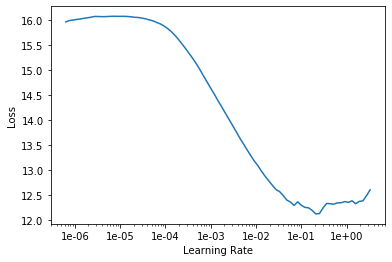

In [16]:
learn.lr_find(); learn.recorder.plot()

In [16]:
learn.fit_one_cycle(4, 1e-2, pct_start=.72)

epoch,train_loss,valid_loss,style,content,time
0,1.052789,0.981352,0.682133,0.299219,03:54
1,0.923205,0.918308,0.606215,0.312093,03:43
2,0.913338,0.891109,0.603479,0.287630,03:44
3,0.849247,0.845553,0.558874,0.286680,03:40


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Using a target size (torch.Size([1, 128, 128])) that is different to the input size (torch.Size([128, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([128, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Using a target size (torch.Size([1, 512, 512])) that is different to the input size (torch.Size([128, 512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Using a target siz

In [17]:
learn.save('res34-128-stage1_0')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Using a target size (torch.Size([1, 128, 128])) that is different to the input size (torch.Size([128, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([128, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Using a target size (torch.Size([1, 512, 512])) that is different to the input size (torch.Size([128, 512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


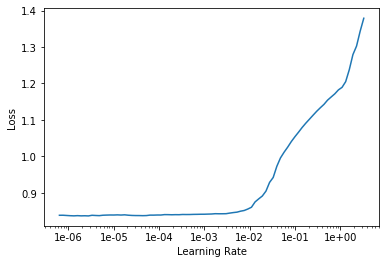

In [20]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot()

In [21]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,style,content,time
0,0.840294,0.843003,0.554802,0.288201,03:46
1,0.835225,0.837154,0.543408,0.293746,03:46
2,0.829194,0.830837,0.540158,0.290679,03:45
3,0.823099,0.824824,0.543262,0.281562,03:45
4,0.816108,0.816106,0.530471,0.285636,03:45
5,0.810755,0.811563,0.524434,0.287130,03:45
6,0.805934,0.808903,0.520244,0.288659,03:46
7,0.804014,0.805935,0.520469,0.285466,03:45


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Using a target size (torch.Size([1, 128, 128])) that is different to the input size (torch.Size([128, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([128, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Using a target size (torch.Size([1, 512, 512])) that is different to the input size (torch.Size([128, 512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Using a target siz

KeyboardInterrupt: 

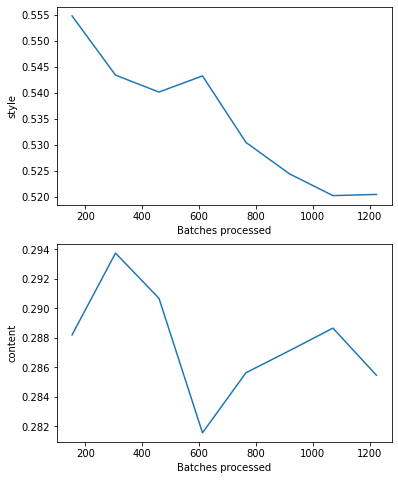

In [22]:
learn.recorder.plot_metrics()

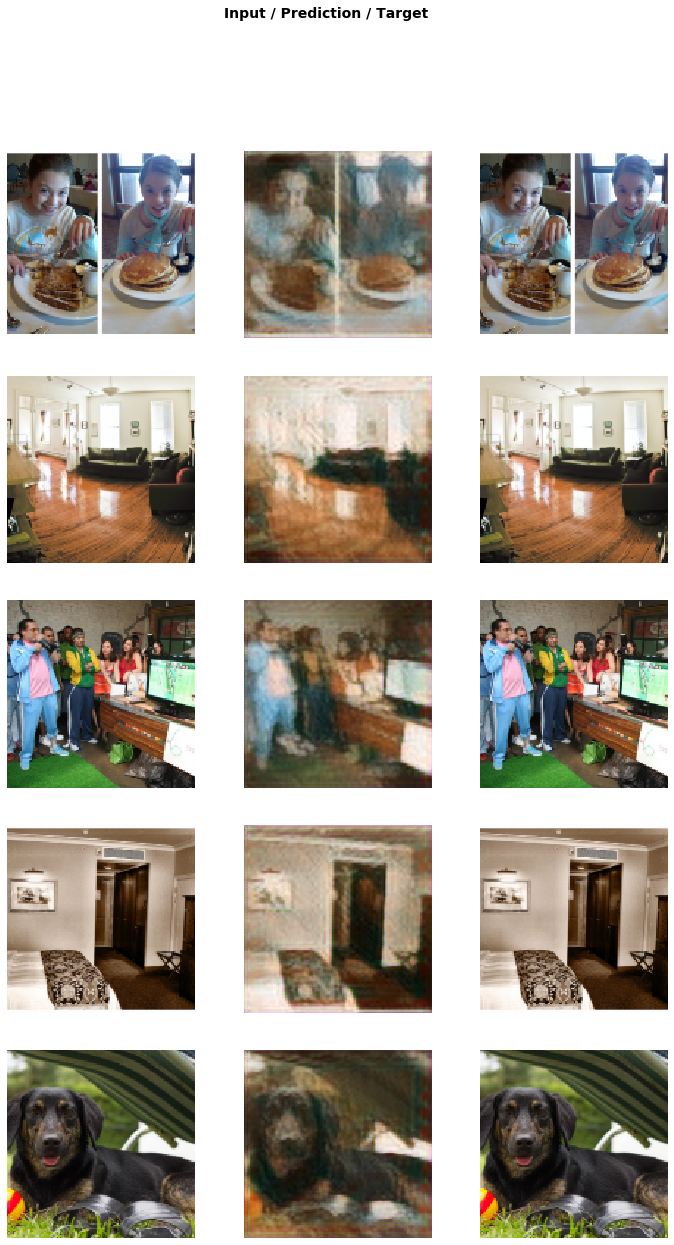

In [23]:
learn.show_results()